In [17]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import torch
import matplotlib.pyplot as plt
from einops import rearrange

from bliss.catalog import TileCatalog, get_images_in_tiles
from bliss.encoder import Encoder
from bliss.catalog import FullCatalog


device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [2]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate

with initialize(config_path="../../coadds/config"):
    cfg = compose("config", overrides=[])

# Run end-to-end

In [3]:
location = instantiate(cfg.models.detection_encoder).to(device).eval()
# NOTE: change weight_checkpoint to the one in your output folder
location.load_state_dict(torch.load('../output/single_encoder.pt', map_location=location.device)
)

encoder = Encoder(location.eval(), n_images_per_batch=10, n_rows_per_batch=15).to(device).eval()

In [35]:
test_ds = torch.load('../output/test_dataset.pt')
image_keys = {"coadd_10", "coadd_25", "coadd_50", "single"}
all_keys = list(test_ds.keys())
truth_params = {k: test_ds.pop(k) for k in all_keys if k not in image_keys}
truth_params["n_sources"] = truth_params["n_sources"].reshape(-1)
truth = FullCatalog(88, 88, truth_params)

In [5]:
background = instantiate(cfg.datasets.galsim_blends.background)
background = background.sample((10000, 1, 88, 88))

In [6]:
tile_est = encoder.variational_mode(test_ds['single'], background)
est = tile_est.cpu().to_full_params()

Encoding ptiles: 1000it [00:32, 30.46it/s]


In [7]:
truth.n_sources

tensor([4, 3, 3,  ..., 2, 2, 5])

In [8]:
est.n_sources

tensor([5, 3, 2,  ..., 2, 2, 5])

In [9]:
from bliss.reporting import DetectionMetrics
results = DetectionMetrics()(truth, est)

Detection Metric per batch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1374.27it/s]


In [10]:
results['recall']

tensor(0.8180)

In [11]:
results['precision']

tensor(0.9378)

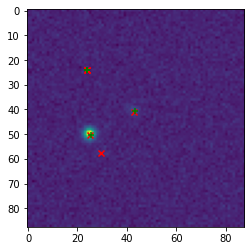

In [14]:
image = test_ds['single'].numpy()[2,0]
tplocs = truth.plocs[2].numpy()
eplocs = est.plocs[2].numpy()

plt.imshow(image)
plt.scatter(tplocs[:, 1] + 24, tplocs[:, 0] + 24, color='r', marker='x')
plt.scatter(eplocs[:, 1] + 24, eplocs[:, 0] + 24, color='g', marker='+')

## metrics per bin

In [16]:
from case_studies.coadds.get_results import _compute_mag_bin_metrics, _add_mags_to_catalog

In [22]:
truth = _add_mags_to_catalog(truth)
est = _add_mags_to_catalog(est)

In [35]:
detection_metrics = DetectionMetrics()
eparams = est.apply_param_bin("mags", 0, 27)

In [37]:
detection_metrics(truth, eparams)
# precision = detection_metrics.compute()["precision"]

Detection Metric per batch: 100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1936.98it/s]


{'tp': tensor(28244),
 'fp': tensor(1872),
 'precision': tensor(0.9378),
 'recall': tensor(0.8180),
 'f1': tensor(0.8738),
 'avg_distance': tensor(0.4329),
 'n_galaxies_detected': tensor(0)}

In [32]:
est.n_sources

tensor([5, 3, 2,  ..., 2, 2, 5])

In [34]:
eparams.n_sources

tensor([5, 3, 2,  ..., 2, 2, 5])

In [18]:
mag_cuts2 = torch.arange(17.0, 23.5, 0.5)
mag_cuts1 = torch.full_like(mag_cuts2, fill_value=-torch.inf)
mag_bins = torch.column_stack((mag_cuts1, mag_cuts2))

TypeError: _compute_mag_bin_metrics() missing 1 required positional argument: 'est'

In [20]:
mag_bins

tensor([[   -inf, 17.0000],
        [   -inf, 17.5000],
        [   -inf, 18.0000],
        [   -inf, 18.5000],
        [   -inf, 19.0000],
        [   -inf, 19.5000],
        [   -inf, 20.0000],
        [   -inf, 20.5000],
        [   -inf, 21.0000],
        [   -inf, 21.5000],
        [   -inf, 22.0000],
        [   -inf, 22.5000],
        [   -inf, 23.0000]])

In [19]:
_compute_mag_bin_metrics(mag_bins, truth, est)

Metrics per bin...: 13it [05:36, 25.87s/it]


{'precision': tensor([0.0237, 0.0368, 0.0513, 0.0682, 0.0893, 0.1140, 0.1408, 0.1714, 0.2061,
         0.2458, 0.2848, 0.3258, 0.3530]),
 'recall': tensor([0.0578, 0.0807, 0.1082, 0.1408, 0.1749, 0.2152, 0.2600, 0.3080, 0.3574,
         0.4099, 0.4599, 0.4983, 0.4824]),
 'tcount': tensor([26690., 27331., 28151., 29202., 30393., 31925., 33853., 36229., 39103.,
         42793., 47289., 52870., 59968.]),
 'ecount': tensor([51114., 51824., 52639., 53620., 54887., 56451., 58245., 60459., 63219.,
         66713., 70668., 75693., 79998.])}

# Results saved

In [3]:
torch.load("../output/metric_results.pt")

{'single': {'mag_cut_metrics': {'precision': tensor([0.9846, 0.9825, 0.9808, 0.9791, 0.9792, 0.9801, 0.9806, 0.9797, 0.9772,
           0.9744, 0.9682, 0.9556, 0.9379]),
   'recall': tensor([0.9899, 0.9916, 0.9895, 0.9875, 0.9852, 0.9856, 0.9831, 0.9801, 0.9759,
           0.9705, 0.9608, 0.9319, 0.8186]),
   'tcount': tensor([ 1490.,  2131.,  2951.,  4002.,  5193.,  6725.,  8653., 11029., 13903.,
           17593., 22089., 27670., 34768.]),
   'ecount': tensor([ 1230.,  1940.,  2755.,  3736.,  5003.,  6567.,  8361., 10575., 13335.,
           16829., 20784., 25809., 30114.])},
  'mag_bin_metrics': {'precision': tensor([0.9930, 0.9914, 0.9949, 0.9882, 0.9898, 0.9883, 0.9833, 0.9736, 0.9679,
           0.9487, 0.9097, 0.8374]),
   'recall': tensor([0.9969, 0.9841, 0.9819, 0.9773, 0.9876, 0.9766, 0.9722, 0.9634, 0.9528,
           0.9272, 0.8240, 0.3714]),
   'tcount': tensor([ 641.,  820., 1051., 1191., 1532., 1928., 2376., 2874., 3690., 4496.,
           5581., 7098.]),
   'ecount': te

# Constant time apply_mag_bin

## 3 dimensions

In [43]:
u = torch.randint(0, 10, (3, 2, 1))
u

tensor([[[4],
         [6]],

        [[2],
         [7]],

        [[0],
         [5]]])

In [44]:
v = torch.randint(0, 20, (3, 2, 2))
v

tensor([[[ 1, 15],
         [18, 12]],

        [[ 4, 14],
         [15,  7]],

        [[ 7, 19],
         [16,  0]]])

In [46]:
as_indices = torch.arange(0, u.shape[1]).expand(u.shape[0], u.shape[1]).unsqueeze(-1)
to_collect = torch.where(u>=5, as_indices, torch.ones_like(u)*(u.shape[1]))
to_collect =to_collect.sort(axis=1)[0]
to_collect = to_collect.expand(to_collect.shape[0], to_collect.shape[1], 2)
to_collect

tensor([[[1, 1],
         [2, 2]],

        [[1, 1],
         [2, 2]],

        [[1, 1],
         [2, 2]]])

In [47]:
v_expand = torch.hstack([v, torch.zeros(v.shape[0], 1, v.shape[-1])])
v_expand

tensor([[[ 1., 15.],
         [18., 12.],
         [ 0.,  0.]],

        [[ 4., 14.],
         [15.,  7.],
         [ 0.,  0.]],

        [[ 7., 19.],
         [16.,  0.],
         [ 0.,  0.]]])

In [48]:
torch.gather(v_expand, 1, to_collect)

tensor([[[18., 12.],
         [ 0.,  0.]],

        [[15.,  7.],
         [ 0.,  0.]],

        [[16.,  0.],
         [ 0.,  0.]]])

In [69]:
v = torch.tensor([[3, 5, 10, 1], [2,4, 1, 99], [9, 1, -1, 2]]).unsqueeze(-1)
u = torch.tensor([[[19,5], [33,1], [112,2], [3232,3]], [[33,4], [1212,5], [444,6], [11,11001]], [[1213211,3], [11,4], [11,-5], [11,-7]]])
u

tensor([[[   11,     5],
         [   11,     1],
         [   11,     2],
         [   11,     3]],

        [[   11,     4],
         [   11,     5],
         [   11,     6],
         [   11, 11001]],

        [[   11,     3],
         [   11,     4],
         [   11,    -5],
         [   11,    -7]]])

In [75]:
indices = torch.arange(0, v.shape[1]).expand(v.shape[0], v.shape[1])
to_collect = torch.where(v>=3, indices.unsqueeze(-1), torch.ones_like(v)*(v.shape[1]))
to_collect =to_collect.sort(axis=1)[0]
to_collect

tensor([[[0],
         [1],
         [2],
         [4]],

        [[1],
         [3],
         [4],
         [4]],

        [[0],
         [4],
         [4],
         [4]]])

In [77]:
v_expand = torch.hstack([v, torch.zeros(v.shape[0], 1, v.shape[-1])])
v_expand

tensor([[[ 3.],
         [ 5.],
         [10.],
         [ 1.],
         [ 0.]],

        [[ 2.],
         [ 4.],
         [ 1.],
         [99.],
         [ 0.]],

        [[ 9.],
         [ 1.],
         [-1.],
         [ 2.],
         [ 0.]]])

## Check new version works

In [59]:
from case_studies.coadds.get_results import _add_mags_to_catalog

In [60]:
truth = _add_mags_to_catalog(truth)

In [76]:
truth_cut = truth.apply_param_bin('mags', 21, 22)

In [77]:
truth['mags'][:5].squeeze(), truth_cut['mags'][:5].squeeze()

(tensor([[20.0560, 21.8985, 21.7439, 21.5681,  0.0000,  0.0000],
         [21.7974, 21.5642, 21.0772,  0.0000,  0.0000,  0.0000],
         [19.3170, 21.4691, 22.6528,  0.0000,  0.0000,  0.0000],
         [22.3313, 18.0336, 21.0293, 20.5252,  0.0000,  0.0000],
         [22.9134, 22.2983, 20.9745, 18.7306, 20.4451,  0.0000]]),
 tensor([[21.8985, 21.7439, 21.5681,  0.0000,  0.0000,  0.0000],
         [21.7974, 21.5642, 21.0772,  0.0000,  0.0000,  0.0000],
         [21.4691,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [21.0293,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]))

In [78]:
truth['star_fluxes'][:5].squeeze(), truth_cut['star_fluxes'][:5].squeeze()

(tensor([[ 9377.1904,  1718.1875,  1981.0428,  2329.2175,     0.0000,     0.0000],
         [ 1885.7545,  2337.6714,  3660.9211,     0.0000,     0.0000,     0.0000],
         [18520.5684,  2551.6023,   857.7312,     0.0000,     0.0000,     0.0000],
         [ 1153.2600, 60399.2695,  3826.0537,  6086.7959,     0.0000,     0.0000],
         [  674.7041,  1188.8411,  4023.8623, 31784.7520,  6552.4717,     0.0000]]),
 tensor([[1718.1875, 1981.0428, 2329.2175,    0.0000,    0.0000,    0.0000],
         [1885.7545, 2337.6714, 3660.9211,    0.0000,    0.0000,    0.0000],
         [2551.6023,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [3826.0537,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000]]))

In [82]:
truth.n_sources[:5], truth_cut.n_sources[:5]

(tensor([4, 3, 3, 4, 5]), tensor([3, 3, 1, 1, 0]))

In [84]:
truth.plocs[:3].squeeze(), truth_cut.plocs[:3].squeeze()

(tensor([[[21.6936, 11.7109],
          [20.4774, 34.8135],
          [28.6949, 10.9999],
          [24.5280, 31.8508],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[39.5405, 28.6831],
          [36.9545, 35.1519],
          [19.0029, 15.9512],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[26.2443,  1.1716],
          [16.8601, 18.9544],
          [33.4359,  5.6533],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]]]),
 tensor([[[20.4774, 34.8135],
          [28.6949, 10.9999],
          [24.5280, 31.8508],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[39.5405, 28.6831],
          [36.9545, 35.1519],
          [19.0029, 15.9512],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[16.8601, 18.9544],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.00

# Constant time boostrap

In [2]:
batch_size = 5
n_bins = 4
n_samples = 3

In [3]:
t = torch.randint(0, 100, (n_bins, batch_size, ))
t

tensor([[96, 81,  2, 20, 88],
        [12, 96, 24, 40, 91],
        [40,  7, 59, 17, 66],
        [95, 55, 35, 71, 24]])

In [4]:
boots = torch.randint(0, batch_size, (n_samples, 1, batch_size,)).expand(n_samples, n_bins, batch_size) 
boots

tensor([[[0, 1, 1, 4, 0],
         [0, 1, 1, 4, 0],
         [0, 1, 1, 4, 0],
         [0, 1, 1, 4, 0]],

        [[4, 3, 1, 2, 3],
         [4, 3, 1, 2, 3],
         [4, 3, 1, 2, 3],
         [4, 3, 1, 2, 3]],

        [[0, 2, 0, 3, 4],
         [0, 2, 0, 3, 4],
         [0, 2, 0, 3, 4],
         [0, 2, 0, 3, 4]]])

In [9]:
result = torch.gather(t.reshape(1, n_bins, batch_size).expand(n_samples, n_bins, batch_size), 2, boots)

In [14]:
result.sum(2).dtype

torch.int64

In [20]:
result.sum(2)

tensor([[442, 307, 160, 324],
        [211, 291, 166, 256],
        [302, 179, 222, 320]])

In [ ]:
result.quantile

In [21]:
torch.quantile(result.sum(2).float(),0.5, 0)

tensor([302., 291., 166., 320.])

# Check boostrap works

In [39]:
from case_studies.coadds.get_results import _get_bootstrap_pr_err, _add_mags_to_catalog

In [17]:
mag_bins2 = torch.arange(17.5, 23.5, 0.5)
mag_bins1 = mag_bins2 - 0.5
mag_bins = torch.column_stack((mag_bins1, mag_bins2))

In [22]:
est["galaxy_bools"] = torch.zeros(est.batch_size, est.max_sources, 1)
truth = _add_mags_to_catalog(truth)
est = _add_mags_to_catalog(est)

In [23]:
_get_bootstrap_pr_err(10, mag_bins, truth, est)

tp/fp per bin: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:43<00:00,  3.64s/it]


{'precision': tensor([[0.9931, 0.9926, 0.9918, 0.9880, 0.9923, 0.9875, 0.9800, 0.9703, 0.9716,
          0.9480, 0.9168, 0.8364],
         [0.9922, 0.9948, 0.9958, 0.9907, 0.9920, 0.9894, 0.9816, 0.9721, 0.9593,
          0.9474, 0.9065, 0.8366],
         [0.9854, 0.9924, 0.9929, 0.9874, 0.9912, 0.9877, 0.9829, 0.9732, 0.9645,
          0.9484, 0.9077, 0.8281],
         [0.9918, 0.9939, 0.9952, 0.9843, 0.9887, 0.9865, 0.9844, 0.9697, 0.9737,
          0.9454, 0.9055, 0.8441],
         [0.9943, 0.9903, 0.9911, 0.9910, 0.9861, 0.9867, 0.9839, 0.9750, 0.9647,
          0.9508, 0.9106, 0.8426],
         [0.9958, 0.9866, 0.9931, 0.9890, 0.9874, 0.9849, 0.9824, 0.9701, 0.9681,
          0.9481, 0.9135, 0.8420],
         [0.9942, 0.9951, 0.9960, 0.9906, 0.9916, 0.9918, 0.9852, 0.9774, 0.9662,
          0.9502, 0.9059, 0.8454],
         [0.9919, 0.9974, 0.9949, 0.9893, 0.9873, 0.9895, 0.9838, 0.9780, 0.9714,
          0.9494, 0.9083, 0.8364],
         [0.9926, 0.9921, 0.9958, 0.9795, 0.9904, 0

## Check results bootstraps

In [24]:
boot_res = torch.load("../output/metric_results.pt")['coadd_10']['boot_mag_bin_metrics']
prec_boot = boot_res['precision']
prec_boot.median(axis=0)[0]
prec_boot.quantile(0.9, 0)

tensor([0.9879, 0.9794, 0.9842, 0.9797, 0.9812, 0.9801, 0.9739, 0.9783, 0.9743,
        0.9587, 0.9446, 0.9538])

tensor([0.9926, 0.9856, 0.9892, 0.9848, 0.9854, 0.9836, 0.9780, 0.9815, 0.9774,
        0.9624, 0.9486, 0.9571])

In [40]:
truth = _add_mags_to_catalog(truth)

In [68]:
mag_bins2 = torch.arange(17.4, 23.0, 0.2)
mag_bins1 = mag_bins2 - 0.2
mag_bins = torch.column_stack((mag_bins1, mag_bins2))

counts_per_bin = torch.zeros(mag_bins.shape[0])
for ii in range(mag_bins.shape[0]):
    mag1, mag2 = mag_bins[ii]
    truth_ = truth.apply_param_bin('mags', mag1, mag2)
    counts_per_bin[ii] = truth_.n_sources.sum().item()

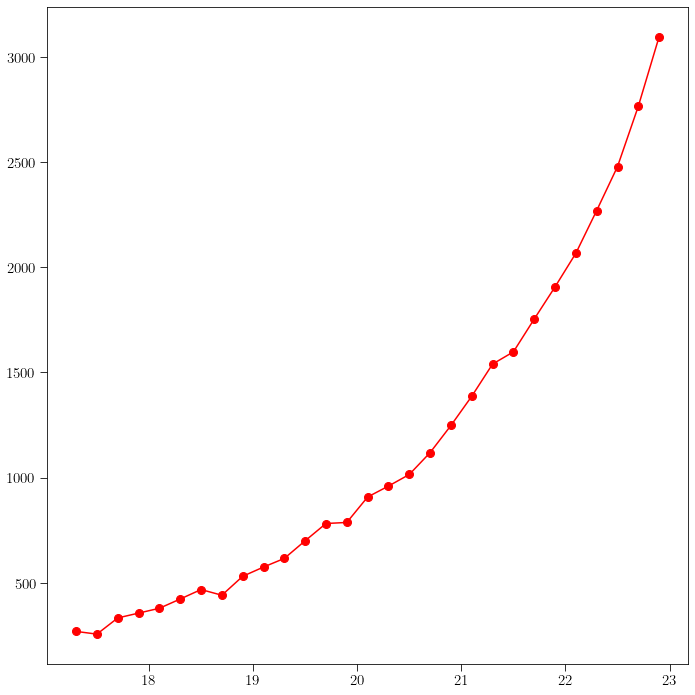

In [69]:
x = mag_bins.mean(axis=1)
plt.plot(x, counts_per_bin, '-ro')

In [70]:
mag_bins

tensor([[17.2000, 17.4000],
        [17.4000, 17.6000],
        [17.6000, 17.8000],
        [17.8000, 18.0000],
        [18.0000, 18.2000],
        [18.2000, 18.4000],
        [18.4000, 18.6000],
        [18.6000, 18.8000],
        [18.8000, 19.0000],
        [19.0000, 19.2000],
        [19.2000, 19.4000],
        [19.4000, 19.6000],
        [19.6000, 19.8000],
        [19.8000, 20.0000],
        [20.0000, 20.2000],
        [20.2000, 20.4000],
        [20.4000, 20.6000],
        [20.6000, 20.8000],
        [20.8000, 21.0000],
        [21.0000, 21.2000],
        [21.2000, 21.4000],
        [21.4000, 21.6000],
        [21.6000, 21.8000],
        [21.8000, 22.0000],
        [22.0000, 22.2000],
        [22.2000, 22.4000],
        [22.4000, 22.6000],
        [22.6000, 22.8000],
        [22.8000, 23.0000]])

In [3]:
import torch
delta = 0.2
mag_bins1 = torch.arange(20.0, 23, delta)
mag_bins2 = mag_bins1 + delta
mag_bins = torch.column_stack((mag_bins1, mag_bins2))

In [4]:
mag_bins

tensor([[20.0000, 20.2000],
        [20.2000, 20.4000],
        [20.4000, 20.6000],
        [20.6000, 20.8000],
        [20.8000, 21.0000],
        [21.0000, 21.2000],
        [21.2000, 21.4000],
        [21.4000, 21.6000],
        [21.6000, 21.8000],
        [21.8000, 22.0000],
        [22.0000, 22.2000],
        [22.2000, 22.4000],
        [22.4000, 22.6000],
        [22.6000, 22.8000],
        [22.8000, 23.0000]])

# Check calibration

In [30]:
import torch
metrics = torch.load("../output/new_models/metrics_mags_poisson.pt")

In [31]:
subset = np.random.randint(0, 1000, 1000)

In [35]:
matched_fluxes = metrics['coadd_50']['matched_fluxes']

In [36]:
tlfluxes = matched_fluxes["true_log_fluxes"]
elfluxes = matched_fluxes["est_log_fluxes"]
sd_elfluxes = matched_fluxes["est_sd_log_fluxes"]
tlfluxes.shape

torch.Size([28283])

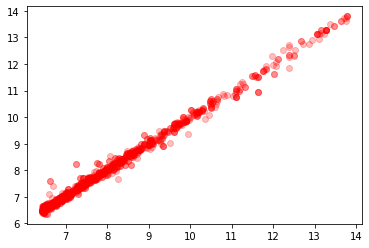

In [37]:
plt.scatter(tlfluxes[subset], elfluxes[subset], alpha=0.25, color='r')

In [10]:
tlfluxes.shape

tensor([10.1496,  6.9274,  7.2274,  ..., 12.1292,  7.4431,  6.8396])

In [11]:
elfluxes

tensor([10.2563,  7.2726,  7.2555,  ..., 12.4482,  7.3966,  7.0592])

In [15]:
sd_elfluxes

tensor([0.2209, 0.1739, 0.1695,  ..., 0.5061, 0.2257, 0.1866])

In [13]:
plt.hist(sd_elfluxes, bins=25)

KeyboardInterrupt: 